(array([ 22.,  78., 109., 128., 151., 145., 132., 116.,  87.,  32.]),
 array([0.00983859, 0.31544932, 0.62106004, 0.92667076, 1.23228148,
        1.5378922 , 1.84350293, 2.14911365, 2.45472437, 2.76033509,
        3.06594581]),
 <BarContainer object of 10 artists>)

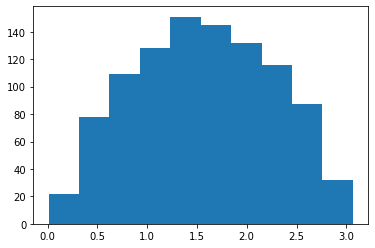

In [11]:
#The functions use eachother and the constants. It is advisable to paste the whole cell into your code, or save it as .py and import it in. 

import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.interpolate import interp1d
import numpy.random as npr
import axispi as axp

#conversion factor
con1 = 2.56819e-3 #MeV−2,  (DCS MeV-2)/con1 = DCS barns
#----------constants-------------
e = 1.6e-19
#Electron and Muon mass squared
mu2 = 105.658**2 #Mev^2
me2 = 0.5110**2 #Mev^2
S = 4*mu2 + 5000 #5000MeV^2 over threshold energy
#---------------------------------

def ab(s):
    #more constants to simplify calculation
    ce = 1-(4*me2/s)
    cu = 1-(4*mu2/s)
    c1 = e**4/(64 * math.pi**2 * s)
    c2 = c1 * cu**(1/2) * ce**(-1/2)

    a = c2 * (1+(4/s)*(me2+mu2))
    b = c2 * (1-(4*mu2/s)) * (1-(4*me2/s))
    return a, b

#differential cross section
def dcs(theta,s):#theta - ejection angle #s - CoM energy squared
    a,b = ab(s)
    return a+b*math.cos(theta)**2

#total cross section
def sigma(s):#s - CoM energy squared
    a,b = ab(s)
    return (4*math.pi/3)*(3*a + b)

#probability density function, PDF of ejection angles
def pdf(theta,s):#theta - ejection angle #s - CoM energy squared
    a,b = ab(s)
    sig = sigma(s)
    DCS = dcs(theta,s)
    return (2*math.pi*math.sin(theta)/sig)*DCS

#Cumulitive Density Function. Probability a THETA sampled is less than theta in the function.
def cdf(theta,s):
    a,b = ab(s)
    sig = sigma(s)
    return (2*math.pi/sig)*((-math.cos(theta)*(3*a+b*math.cos(theta)**2)*1/3)+ a)

#Theta Generation, Sampling from the PDF, Using Inverse CDF Method
def thetaGen2(howMany):#howMany - the number of thetas to generate
    #generate the lookup table for the inverse function
    theta = np.linspace(0,math.pi,100)
    CDF = [cdf(x,S) for x in theta]
    PDF = [pdf(x,S) for x in theta]
    #thetaPredictor is the inverse CDF brought about using a look up table (theta,CDF) and interpolation
    thetaPredictor = interp1d(CDF, theta, kind = "linear")
    return [float(thetaPredictor(x)) for x in npr.uniform(min(CDF),max(CDF),howMany)]

